# Deep Learning with Python
# 6.2 - Word Embeddings
## What?
- **One-hot encoding** or one-hot hashing creates word vectors that are
    - High dimensional (> 20k tokens so 20k dimensions)
    - Sparse: All elements are 0, only the index corresponding to a specific word is 1. 
    - Binary: The value of any element in a one-hot vector is either 1 or 0.
    - Explicilty defined or hardcoded, not learned through a machine learning algorithm. 
- **Word embeddings** are vectors of words that are
    - Low-dimensional: Word-embedding vectors are 256, 512, or 1024 dimensional for vocabularies of 20k words or more. They pack a lot more words/information in lower dimensions.
    - Floating point: Not binary. Each element can be a floating point number. Makes them amenable to tensor models.
    - Learned from data.
    
Two ways to obtain word embeddings
- Learn word embeddings jointly with training your model.
- Use preconfigured or pretrained word embeddings that were computed using a different machine learning task than the one you are trying to solve.

### TLDR: Word Embeddings
- Word embeddings map words in the vocabulary for a specific machine learning task to a geometric space.
- The separation between individual words in this vector space (such as L2 norm) is analogous to the semantic difference between the words.
- Embedding vectors represent transformations that express relationships between words in a word embedding vector space. 
- E.g. a `female` word embedding vector, when added to the `King` in a word embedding vector space, will form `queen`. 

## Learning Word Embeddings
### Why?
- No universal word embedding space that can be used for all languages and all possible NLP tasks.
- All languages are different and are not isomorphic: relationships in one language's word-embedding space may not be transferable to that of another language.
- In fact, even within the same language, word embedding spaces differ from one application to another.
- So it's a good idea to learn a word-embedding space from scratch when working on a new ML problem.

In [17]:
from tensorflow.keras.layers import Embedding

Embedding layer is best understood as a dictionary that mps integer indices (which represent specific words) to dense vectors. It takes integers (indices) as inputs, looks up these integrs in an internal dictionary, and returns the associated vectors as ouput. 

In this case, the Embedding layer recieves an input tensor containing up to 1000 word tokens (indices representing up to 1000 words in the total vocabulary for our samples) and will return the vectors representing each word as a 64 dimensional word-embedding space vector. 

In [18]:
# Arg 1: Number of possible tokens - 1000 = 1 + maximum word index
# Arg 2: Dimensionality - 64 - Ou
embedding_layer = Embedding(1000, 64)

In [19]:
embedding_layer.input_dim

1000

In [20]:
embedding_layer.output_dim

64

Embedding Layer will take as input a 2D tensor of integers of shape `(samples, sequence_length)`. Here, each entry represents a single sample and each sample is a sequence of integers. All sample vectors must have the same length, so individual sample vectors may have to be zero-padded. 

The output will be a 3D `float32` tensor of shape `(samples, sequence_length, embedding_dimensionality)` where each sample is will consist of the sequence of words, and each word will be represented as an `N` dimensional vector, where `N` is the dimensionality of the word-embedding vector space.

## Learning Embedding for `imdb`

1. Prepare data by tokenizing it to a sequence of integers.
2. Restrict the movie reviews to the top 10k most common words.
3. Parse only the first 20 words in each review for tokenizing.
4. Feed each sequence of integers to the Embedding layer which will convert each word (integer) to an 8-dimensional vector. 
5. Flatten the tensor to 2D.
6. Train a single `Dense` layer on top for classification.

In [21]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

In [22]:
# Number of words to consider as features
max_features = 10000

# Cuts off the text after this number of words
maxlen = 20

In [23]:
# for loading IMDB dataset from a pickle file
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
# Data is loaded as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# restore np.load for future normal usage
np.load = np_load_old

### Preprocesing
 Turn the list of training and test integers into 2D integer tensor of shape `(samples, maxlen)`. This means any reviews that have less than 20 words will have to be zero-padded. 

In [24]:
# Turns list of training integers into 2D integer tensor
# shape (samples, maxlen) - 0 padding for reviews that are less than 20 words
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)

In [25]:
# Do the same for the test samples
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

## Using `Embedding` Layer and Classifier on IMDB Data

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

In [27]:
model = Sequential()

The Embedding layer will accept inputs with upto 10k different words and encodes each word as an 8 dimensional word-embedding vector. The `input_length` argument specifies the dimension of each input to the layer along the samples axis.

In [28]:
# Specifies maximum input length to Embeddinag layer
# So embedded inputs can later be flattened
model.add(Embedding(10000, 8, input_length=maxlen))

In [29]:
# Flatten the 3D tensor of embeddings into a 2D tensor of shape
# (samples, maxlen * 8)
model.add(Flatten())

In [30]:
# Add a classifier on top 
# But this will treat each word in the sample separately
# Without considering inter-word relationships and structure
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(x_train, y_train, 
                   epochs=10, batch_size=32, 
                   validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
20000/20000 [==============================] - 3s 169us/sample - loss: 0.6633 - acc: 0.6349 - val_loss: 0.6048 - val_acc: 0.7014
Epoch 2/10
20000/20000 [==============================] - 2s 107us/sample - loss: 0.5291 - acc: 0.7531 - val_loss: 0.5196 - val_acc: 0.7314
Epoch 3/10
20000/20000 [==============================] - 2s 108us/sample - loss: 0.4571 - acc: 0.7893 - val_loss: 0.5000 - val_acc: 0.7474
Epoch 4/10
20000/20000 [==============================] - 2s 117us/sample - loss: 0.4228 - acc: 0.8073 - val_loss: 0.4948 - val_acc: 0.7516
Epoch 5/10
20000/20000 [==============================] - 2s 120us/sample - loss: 0.3995 - acc: 0.8196 - val_loss: 0.4943 - val_acc: 0.7534
Epoch 6/10
20000/20000 [==============================] - 2s 109us/sample - loss: 0.3802 - acc: 0.8313 - val_loss: 0.4976 - val_acc: 0.7546
Epoch 7/10
20000/20000 [==============================] - 2s 11

Get a validation accuracy of 76%, which is good considering that we were only using the first 20 words in each review for learning word embeddings. 

The use of a densely connected classifier without an RNN or Conv1D layer is not the optimal way of learning word embeddings. This is because this architecture will only allow the NN to focus on individual words in the input sequences without considering inter-word relationshops and sentence structure.

So this network would be unable to differentiate between "This movie is a bomb" and "This move is the bomb".

## Pretrained Word Embeddings

To integrate pretrained word embeddings with our model, we must use the original IMDB data. This is because the IMDB data accessible through built-in `keras` functionality already has associations/its own encoding. We want the machine learnign algorithm to assign these encodings from scratch.

In [119]:
import os

In [120]:
# Path to original IMDB dataset on Drive
imdb_dir = '/Users/saads/OneDrive/Desktop/DL-Python-Repo/FYP-DL/Dl-Python-Book/chapter-6/aclImdb'

In [121]:
# Path to training directory - renamed to test in the new download
train_dir = os.path.join(imdb_dir, 'test')

In [122]:
# Empty lists to store class and extracted text from all reviews
labels = []
texts = []

In [123]:
pos_files = os.listdir(os.path.join(train_dir, 'pos'))
neg_files = os.listdir(os.path.join(train_dir, 'neg'))

In [124]:
pos_files[0][-4:]

'.txt'

In [125]:
# Parse all .txt files in the `neg` and `pos` subdirectories of 
# the training set. Read all reviews and add their text and labels to the 
# appropriate lists. 
for label_type in ['neg', 'pos']:
    # Parse the negative and positive class directories in turn
    dir_name = os.path.join(train_dir, label_type)
    
    # For every file in the subdirectory
    for fname in os.listdir(dir_name):
        # Check if it's a text file. DON'T FORGET CLOSING COLON FOR THE LIST SLICING
        if fname[-4:] == '.txt':
            # Open it, read its contents, append them to the texts list
            # Must specify UTF-8 encoding, otherwise Python has issues reading from file
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            
            # Close the filestream
            f.close()
            
            # For each review added to the texts list, also add
            # 1 or 0 to the labels category on the corresponding index
            if label_type == 'neg':
                labels.append(0)  # negative class
            else:
                labels.append(1)  # positive class

### Tokenizing Data

The data is now ready to be tokenized i.e. converted from string to a series of integer indices, each of which represents a single word in the vocabulary.

A condition where pre-trained word embeddings are practically useful is when we have very little training data available to learn our own embeddings. To simulate this condition, we will limit ourselves to using only 200 samples fromn the training data.

In [141]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [142]:
# Cuts off reviews after 100 words
maxlen = 100

# Trains on only 200 samples - simulating limited training data 
training_samples = 200

# Validate on 10k samples
validation_samples = 10000

# Considers only the top 10k words in the dataset
max_words = 10000

In [143]:
# Instantiate a keras tokenizer for 10k words
tokenizer = Tokenizer(num_words=max_words)

# Tokenize all words in the training data
tokenizer.fit_on_texts(texts)

# Convert the samples to sequences of tokens
sequences = tokenizer.texts_to_sequences(texts)

In [144]:
# Dictionary that maps each word in the vocabulary to an index
word_index = tokenizer.word_index

In [145]:
print('Found %s unique tokens.' % len(word_index))

Found 72633 unique tokens.


In [146]:
data = pad_sequences(sequences, maxlen=maxlen)

In [147]:
labels = np.asarray(labels)

In [148]:
print("Shape of data tensor: ", data.shape)

Shape of data tensor:  (17243, 100)


In [149]:
print("Shape of label tensor: ", data.shape)

Shape of label tensor:  (17243, 100)


In [150]:
# Split the data into a training set and validation set
# But first shuffle the data b/c we're starting with data
# in which samples are ordered (all negative first, then all positive)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [152]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [153]:
print(x_train.shape)

(200, 100)


In [154]:
print(y_train.shape)

(200,)


In [155]:
print(x_val.shape)

(10000, 100)


In [156]:
print(y_val.shape)

(10000,)


## GloVe Word Embeddings

In [157]:
# Path to directory with GloVe word embeddings
glove_dir = '/Users/saads/OneDrive/Desktop/DL-Python-Repo/FYP-DL/Dl-Python-Book/chapter-6/glove-6B'

In [158]:
# Dictionary that will map GloVe word embeddings to indices
embeddings_index = {}

In [160]:
# Open the word embedding file containing 100-dimensional embeddings
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf-8')

In [161]:
# For every line in this file 
for line in f:
    # Split the line into an array of individual vaues
    values = line.split()
    
    # The first value in each line is the word
    word = values[0]
    
    # The remaining values in the line are coeffs of a 100-dimensional vector
    # Encoding that word
    coefs = np.asarray(values[1:], dtype='float32')
    
    # Add the word as a key to the embeddings dictionary, with coeffs as value
    embeddings_index[word] = coefs
    
f.close()

In [162]:
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


Building an embedding matrix. This matrix will then be loaded into an `Embedding` layer. It must be a matrix of shape `(max_words, embedding_dim)`. Each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in the reference word index that was build during tokenization.

Index 0 isn't supposed to stand for any word or token. It is a placeholder.

In [163]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

# Key is the word, its index is the word vector        
for word, i in word_index.items():
    # Word index is the dictionary of distinct words in the IMDB dataaset
    # Every word is encoded as a specific numeric integer
    if i < max_words:
        # Get the word corresponding vector for this word
        # This will be from the GloVe embeddings dictionary 
        # Where each word is encoded as a VECTOR of integers
        embedding_vector = embeddings_index.get(word)
        
        # Set value if not in embedding matrix
        if embedding_vector is not None:
            # Words not found in the embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

### GloVe Model
Identical to the previous model

In [164]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

In [165]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


## Loading the GloVe Embeddings n the Model

Weight matrix of the embedding layer is a 2D float matrix where each entry `i` is the word vector meant to be associated with the index `i`. 

In [166]:
model.layers[0].set_weights([embedding_matrix])

# Embedding layer's weights are not trainable
# Want to reuse preconfigured features in the word-embedding
model.layers[0].trainable = False

In [ ]:
## Train the Model

In [167]:
# Training the model
model.compile(optimizer='rmsprop', 
             loss='binary_crossentropy', 
             metrics=['acc'])

In [168]:
history_glove = model.fit(x_train, y_train, 
                   epochs=10, batch_size=32, 
                   validation_data=(x_val, y_val))

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 6ms/sample - loss: 2.8250 - acc: 0.6300 - val_loss: 0.6949 - val_acc: 0.5620
Epoch 2/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.4690 - acc: 0.8000 - val_loss: 0.7264 - val_acc: 0.5101
Epoch 3/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.3918 - acc: 0.8300 - val_loss: 2.0287 - val_acc: 0.2772
Epoch 4/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.3424 - acc: 0.8750 - val_loss: 0.8291 - val_acc: 0.7212
Epoch 5/10
200/200 [==============================] - 1s 5ms/sample - loss: 0.1276 - acc: 0.9900 - val_loss: 0.7659 - val_acc: 0.7104
Epoch 6/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.0594 - acc: 0.9950 - val_loss: 1.2772 - val_acc: 0.7228
Epoch 7/10
200/200 [==============================] - 1s 5ms/sample - loss: 0.1271 - acc: 0.9800 - val_loss: 0.6964 - val_acc: 0.6217
Epoch 8/10
200

## Save the Model

In [169]:
model.save_weights('pre_trained_glove_model.h5')

## Plotting Model Performance

In [170]:
import matplotlib.pyplot as plt

In [171]:
acc = history_glove.history['acc']
val_acc = history_glove.history['val_acc']
loss = history_glove.history['loss']
val_loss = history_glove.history['val_loss']
epochs = range(1, len(acc) + 1)

Text(0.5, 1.0, 'GloVe Embeddings - Accuracy')

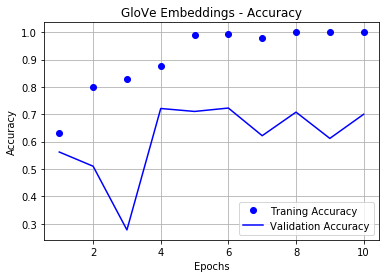

In [172]:
plt.plot(epochs, acc, 'bo', label='Traning Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.grid(True);
plt.legend(); plt.title('GloVe Embeddings - Accuracy')

Text(0.5, 1.0, 'GloVe Embeddings - Loss')

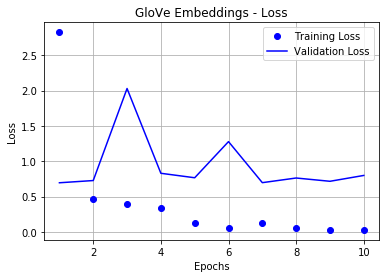

In [173]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.grid(True);
plt.legend(); plt.title('GloVe Embeddings - Loss')

### Explanation
- The model shows evidence of overfitting from early epochs, which is not surprising because we are training on a dataset of only 200 samples. 
- Also, the plots don't exactly match those from the book because the training set is very small, so the weights depend on which specific samples from the original dataset were used for the 200 sample training set.
- Validation accuracy also has a high variance for the same reason.

## Training w/o GloVe Embeddings
- Going to use the same 200 samples to also learn a custom word embedding for our model along with training it.

In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

In [175]:
model = Sequential()

In [176]:
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [177]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [178]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
             metrics=['acc'])

In [179]:
history_custom_embed = model.fit(x_train, y_train, epochs=10, batch_size=32, 
                   validation_data=(x_val, y_val))

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 7ms/sample - loss: 0.6649 - acc: 0.7150 - val_loss: 0.6223 - val_acc: 0.7231
Epoch 2/10
200/200 [==============================] - 1s 5ms/sample - loss: 0.4468 - acc: 0.7700 - val_loss: 0.6040 - val_acc: 0.7229
Epoch 3/10
200/200 [==============================] - 1s 5ms/sample - loss: 0.2845 - acc: 0.9650 - val_loss: 0.6033 - val_acc: 0.7230
Epoch 4/10
200/200 [==============================] - 1s 7ms/sample - loss: 0.1431 - acc: 0.9950 - val_loss: 0.6121 - val_acc: 0.7158
Epoch 5/10
200/200 [==============================] - 1s 5ms/sample - loss: 0.0706 - acc: 1.0000 - val_loss: 0.6258 - val_acc: 0.7207
Epoch 6/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.0360 - acc: 1.0000 - val_loss: 0.6398 - val_acc: 0.7229
Epoch 7/10
200/200 [==============================] - 1s 5ms/sample - loss: 0.0197 - acc: 1.0000 - val_loss: 0.6698 - val_acc: 0.7227
Epoch 8/10
200

In [180]:
acc = history_custom_embed.history['acc']
val_acc = history_custom_embed.history['val_acc']
loss = history_custom_embed.history['loss']
val_loss = history_custom_embed.history['val_loss']
epochs = range(1, len(acc) + 1)

Text(0.5, 1.0, 'Custom Embedding Layer Model - Accuracy')

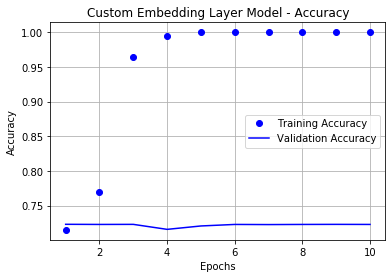

In [182]:
# Plotting accuracy
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.grid(True);
plt.legend(); plt.title('Custom Embedding Layer Model - Accuracy')

Text(0.5, 1.0, 'Custom Embedding Model - Loss')

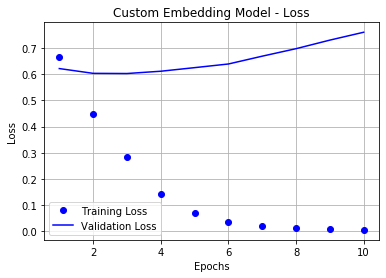

In [184]:
# Loss
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.grid(True); plt.title('Custom Embedding Model - Loss')

## Evaluating Model
Can't do this. The acl

In [185]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

In [ ]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name))
    if fname[-4:] == '.txt':
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        
        if label_type == 'neg':
            labels.append(0)
            
        else:
            labels.append(1)

In [ ]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [ ]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)